In [1]:
#import wrangle
import Acquire_for_Regression_Project as a

#import importlib import reload

import numpy as np
np.random.seed(198)
import pandas as pd
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt

import sklearn.preprocessing as pre
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression

import warnings
warnings.filterwarnings("ignore")

# 1. Acquire

In [2]:
df = a.new_zillow_data()

# 2. Clean

In [3]:
df = a.clean_data(df)

# 3. Split 

In [4]:
train, validate, test = a.split_data(df)

In [5]:

X_cols = ['bed_rooms', 
          'bath_rooms', 
          'year_built', 
          'county_Orange', 
          'county_Ventura',
          'house_square_feet',
          'property_square_feet',
          'property_age']

target = ['property_value']

In [6]:
X_train = train[X_cols]
y_train = train[target]

X_validate = validate[X_cols]
y_validate = validate[target]

X_test = test[X_cols]
y_test = test[target]

# 4. Feature Engineering

### Ratio of bedrooms to bathrooms

In [7]:
train["bed_to_bath_ratio"] = train.bed_rooms/train.bath_rooms
validate["bed_to_bath_ratio"] = validate.bed_rooms/validate.bath_rooms
test["bed_to_bath_ratio"] = test.bed_rooms/test.bath_rooms

In [8]:
X_train["bed_to_bath_ratio"] = train.bed_rooms/train.bath_rooms
X_validate["bed_to_bath_ratio"] = validate.bed_rooms/validate.bath_rooms
X_test["bed_to_bath_ratio"] = test.bed_rooms/test.bath_rooms

In [9]:
train["bed_to_bath_ratio"]=train["bed_to_bath_ratio"].astype(int)
validate["bed_to_bath_ratio"]=validate["bed_to_bath_ratio"].astype(int)
test["bed_to_bath_ratio"]=test["bed_to_bath_ratio"].astype(int)

In [10]:
train.bed_to_bath_ratio.round(1)

11083    1
8092     1
42166    3
31530    2
44100    2
        ..
26940    2
6326     1
41051    1
9370     1
9230     3
Name: bed_to_bath_ratio, Length: 26946, dtype: int64

### Ratio of house square feet : lot square feet

In [11]:
train["house_to_lot_sqft_ratio"]=train.house_square_feet/train.property_square_feet
validate["house_to_lot_sqft_ratio"]=validate.house_square_feet/validate.property_square_feet
test["house_to_lot_sqft_ratio"]=test.house_square_feet/test.property_square_feet

In [12]:
X_train["house_to_lot_sqft_ratio"]=train.house_square_feet/train.property_square_feet
X_validate["house_to_lot_sqft_ratio"]=validate.house_square_feet/validate.property_square_feet
X_test["house_to_lot_sqft_ratio"]=test.house_square_feet/test.property_square_feet

In [13]:
train.house_to_lot_sqft_ratio.round(2)

11083    0.88
8092     0.46
42166    0.66
31530    0.23
44100    0.10
         ... 
26940    0.30
6326     0.09
41051    0.04
9370     0.33
9230     0.22
Name: house_to_lot_sqft_ratio, Length: 26946, dtype: float64

In [14]:
train.head()

,bath_rooms,bed_rooms,property_value,house_square_feet,property_square_feet,property_age,year_built,county,county_Orange,county_Ventura,bed_to_bath_ratio,house_to_lot_sqft_ratio
11083,2,3,517777.0,1745,1988,28,1989,Orange,1,0,1,0.877767
8092,2,3,518740.0,1853,4000,31,1986,Ventura,0,1,1,0.463250
42166,1,3,286606.0,1698,2588,38,1979,Ventura,0,1,3,0.656105
31530,2,5,446000.0,1546,6749,72,1945,LA,0,0,2,0.229071
44100,1,2,41372.0,992,9884,92,1925,LA,0,0,2,0.100364


# 5. Scale

Text(0.5, 1.0, 'Scaled')

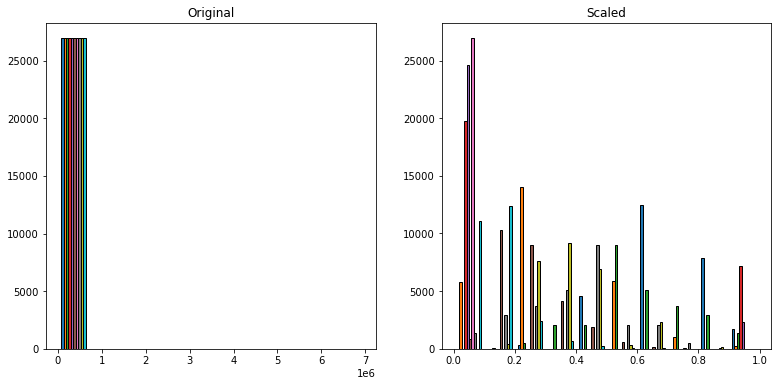

In [15]:
MM_scaler = pre.MinMaxScaler()
# Note that we only call .fit with the training data,
# but we use .transform to apply the scaling to all the data splits.

# Make copies of train, validate, and test dfs
MM_X_train_scaled = X_train.copy()
MM_X_validate_scaled = X_validate.copy()
MM_X_test_scaled = X_test.copy()

# Fit scaler to Train df
MM_scaler.fit(X_train)

# Transform data from three dfs
MM_X_train_scaled = MM_scaler.transform(X_train)
MM_X_validate_scaled = MM_scaler.transform(X_validate)
MM_X_test_scaled = MM_scaler.transform(X_test)

#Shove it back into a dataframe
MM_X_train_scaled = pd.DataFrame(MM_X_train_scaled, columns = X_train.columns, index = X_train.index)

# Plot figure
plt.figure(figsize=(13, 6))
plt.subplot(121)
plt.hist(X_train, ec='black')
plt.title('Original')
plt.subplot(122)
plt.hist(MM_X_train_scaled, ec='black')
plt.title('Scaled')


In [16]:
MM_X_train_scaled.head()

,bed_rooms,bath_rooms,year_built,county_Orange,county_Ventura,house_square_feet,property_square_feet,property_age,bed_to_bath_ratio,house_to_lot_sqft_ratio
11083,0.6,0.25,0.810219,1.0,0.0,0.241217,0.000216,0.189781,0.3,0.422084
8092,0.6,0.25,0.788321,0.0,1.0,0.257571,0.000505,0.211679,0.3,0.222718
42166,0.6,0.00,0.737226,0.0,1.0,0.234101,0.000302,0.262774,0.6,0.315474
31530,1.0,0.25,0.489051,0.0,0.0,0.211084,0.000899,0.510949,0.5,0.110087
44100,0.4,0.00,0.343066,0.0,0.0,0.127196,0.001349,0.656934,0.4,0.048184


Text(0.5, 1.0, 'Scaled')

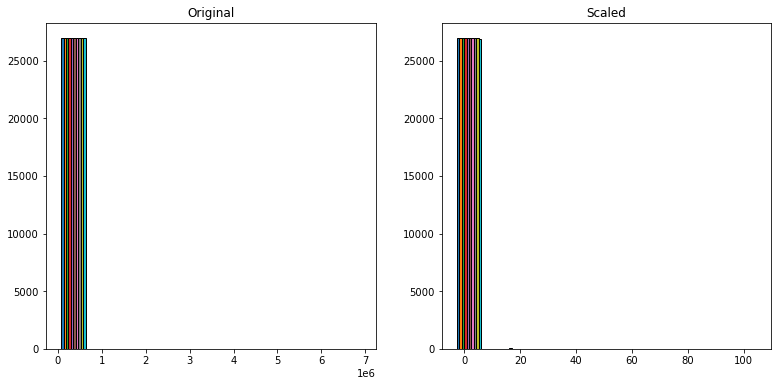

In [17]:
# set scaler as Standard Scaler
Stand_scaler = pre.StandardScaler()

# Make copies of train, validate, and test dfs
Stand_X_train_scaled = X_train.copy()
Stand_X_validate_scaled = X_validate.copy()
Stand_X_test_scaled = X_test.copy()

# Fit scaler to Train df
Stand_scaler.fit(X_train)

# Transform data from three dfs
Stand_X_train_scaled = Stand_scaler.transform(X_train)
Stand_X_validate_scaled = Stand_scaler.transform(X_validate)
Stand_X_test_scaled = Stand_scaler.transform(X_test)
             
#Shove it back into a dataframe
Stand_X_train_scaled = pd.DataFrame(Stand_X_train_scaled, columns = X_train.columns, index = X_train.index)

# Plot figure
plt.figure(figsize=(13, 6))
plt.subplot(121)
plt.hist(X_train, ec='black')
plt.title('Original')
plt.subplot(122)
plt.hist(Stand_X_train_scaled, ec='black')
plt.title('Scaled')    
    

In [18]:
Stand_X_train_scaled.head()

,bed_rooms,bath_rooms,year_built,county_Orange,county_Ventura,house_square_feet,property_square_feet,property_age,bed_to_bath_ratio,house_to_lot_sqft_ratio
11083,-0.265941,-0.126768,1.182947,1.659509,-0.309678,-0.040706,-0.120577,-1.182947,-0.315439,3.529187
8092,-0.265941,-0.126768,1.048988,-0.602588,3.229161,0.106498,-0.090019,-1.048988,-0.315439,1.115913
42166,-0.265941,-1.372530,0.736416,-0.602588,3.229161,-0.104767,-0.111464,-0.736416,2.240442,2.238696
31530,2.097533,-0.126768,-0.781788,-0.602588,-0.309678,-0.311944,-0.048267,0.781788,1.388482,-0.247453
44100,-1.447679,-1.372530,-1.674850,-0.602588,-0.309678,-1.067047,-0.000653,1.674850,0.536522,-0.996771


### use the standard scaler

In [19]:
# saving a copy of the training set im going to move forward with to a less cumbersome name
train_scaled = Stand_X_train_scaled.copy()

# Exploration and Visualization

 Hypothesis 1: The more square footage a house has, the more expensive it will be
 
 - H_0: square footage is independet of value
 - H_a: square footage is positively correlated to value

In [20]:
price_corr = train.drop(columns = ['county']).corr()
price_corr

,bath_rooms,bed_rooms,property_value,house_square_feet,property_square_feet,property_age,year_built,county_Orange,county_Ventura,bed_to_bath_ratio,house_to_lot_sqft_ratio
bath_rooms,1.000000,0.598619,0.418801,0.782674,0.027446,-0.513404,0.513404,0.074521,0.051545,-0.664675,0.239975
bed_rooms,0.598619,1.000000,0.248474,0.619171,0.011750,-0.405418,0.405418,0.122087,0.111176,-0.013466,0.160230
property_value,0.418801,0.248474,1.000000,0.518246,0.008512,-0.259422,0.259422,0.168375,0.063695,-0.236344,0.230285
house_square_feet,0.782674,0.619171,0.518246,1.000000,0.039983,-0.495106,0.495106,0.151267,0.093685,-0.372083,0.289680
property_square_feet,0.027446,0.011750,0.008512,0.039983,1.000000,-0.029881,0.029881,-0.028044,0.005554,-0.016967,-0.081442
property_age,-0.513404,-0.405418,-0.259422,-0.495106,-0.029881,1.000000,-1.000000,-0.288279,-0.178094,0.336638,-0.344720
year_built,0.513404,0.405418,0.259422,0.495106,0.029881,-1.000000,1.000000,0.288279,0.178094,-0.336638,0.344720
county_Orange,0.074521,0.122087,0.168375,0.151267,-0.028044,-0.288279,0.288279,1.000000,-0.186608,-0.041990,0.360089
county_Ventura,0.051545,0.111176,0.063695,0.093685,0.005554,-0.178094,0.178094,-0.186608,1.000000,-0.009804,-0.016767
bed_to_bath_ratio,-0.664675,-0.013466,-0.236344,-0.372083,-0.016967,0.336638,-0.336638,-0.041990,-0.009804,1.000000,-0.141428


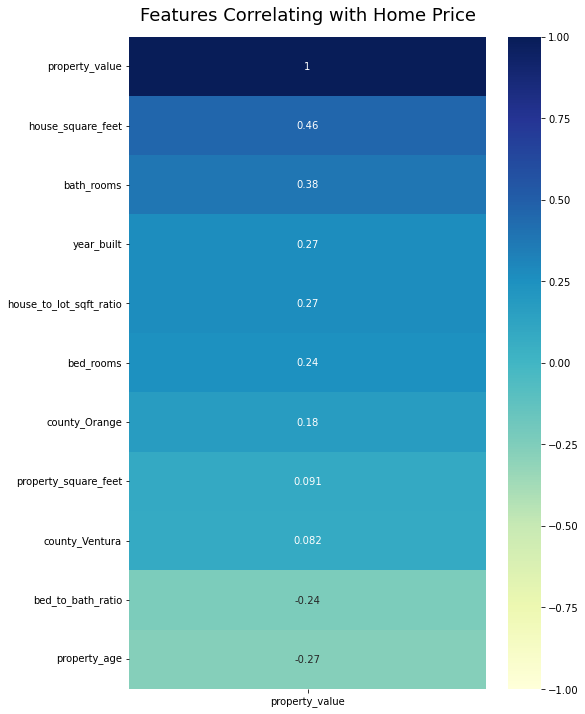

In [21]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(train.drop(columns = ['county']).corr(method='spearman')[['property_value']].sort_values(by='property_value', ascending=False), vmin=-1, vmax=1, annot=True, cmap='YlGnBu')
heatmap.set_title('Features Correlating with Home Price', fontdict={'fontsize':18}, pad=16);

We now know that house square footage is most correlated to the price of the house, but is it positive or negative?


<AxesSubplot:xlabel='house_square_feet', ylabel='property_value'>

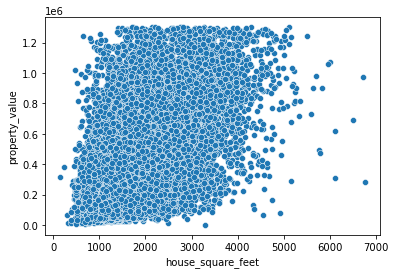

In [38]:
sns.scatterplot(data = train, x='house_square_feet', y= 'property_value')

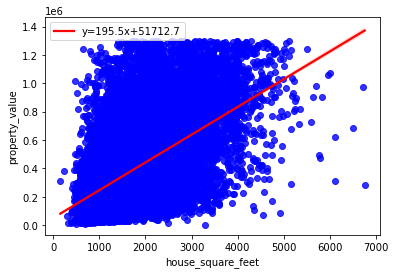

In [49]:
# get coeffs of linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(train['house_square_feet'],train['property_value'])

# use line_kws to set line label for legend
ax = sns.regplot(x="house_square_feet", y="property_value", data=train, color='b', 
 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept), 'color': 'red'})

# plot legend
ax.legend()

plt.show()

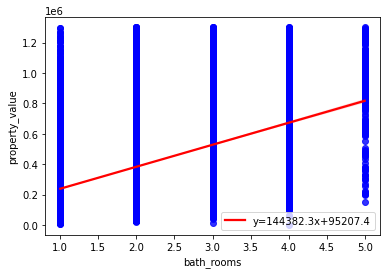

In [50]:
# get coeffs of linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(train['bath_rooms'],train['property_value'])

# use line_kws to set line label for legend
ax = sns.regplot(x="bath_rooms", y="property_value", data=train, color='b', 
 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept), 'color': 'red'})

# plot legend
ax.legend()

plt.show()

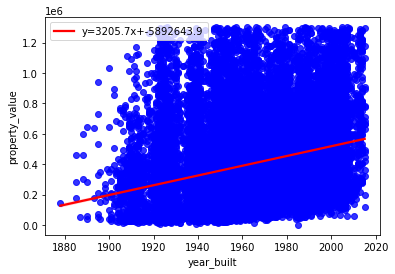

In [51]:
# get coeffs of linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(train['year_built'],train['property_value'])

# use line_kws to set line label for legend
ax = sns.regplot(x="year_built", y="property_value", data=train, color='b', 
 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept), 'color': 'red'})

# plot legend
ax.legend()

plt.show()

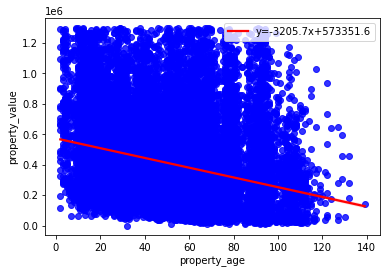

In [52]:
# get coeffs of linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(train['property_age'],train['property_value'])

# use line_kws to set line label for legend
ax = sns.regplot(x="property_age", y="property_value", data=train, color='b', 
 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept), 'color': 'red'})

# plot legend
ax.legend()

plt.show()

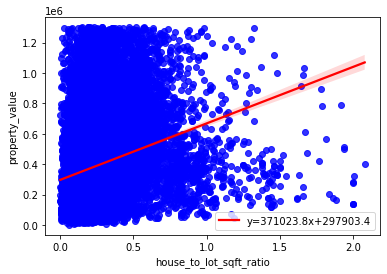

In [53]:
# get coeffs of linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(train['house_to_lot_sqft_ratio'],train['property_value'])

# use line_kws to set line label for legend
ax = sns.regplot(x="house_to_lot_sqft_ratio", y="property_value", data=train, color='b', 
 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept), 'color': 'red'})

# plot legend
ax.legend()

plt.show()

#  Evaluate Features

### Select K Best

In [24]:
f_selector = SelectKBest(f_regression, k=3)

In [25]:
f_selector.fit(X_train, y_train)


SelectKBest(k=3, score_func=<function f_regression at 0x1208780d0>)

In [26]:
X_best_features = f_selector.transform(X_train)

print(X_best_features.shape)

(26946, 3)


In [27]:
f_support = f_selector.get_support()

In [28]:
f_feature = X_train.loc[:,f_support].columns.tolist()

# you could also get the list this way (among many others)
# f_feature = [X_train_scaled.columns.values[i] for i in range(len(feature_mask)) if feature_mask[i]==True]

print(str(len(f_feature)), 'selected features')
print(f_feature)


3 selected features
['bath_rooms', 'house_square_feet', 'property_age']


### RFE

In [29]:
lm = LinearRegression()

In [30]:
rfe = RFE(lm, n_features_to_select = 3)

In [31]:
# Transforming data using RFE
X_rfe = rfe.fit_transform(X_train,y_train)  


In [32]:
lm.fit(X_rfe, y_train)

LinearRegression()

In [33]:
mask = rfe.support_

In [34]:
rfe_features = X_train.loc[:,mask].columns.tolist()

In [35]:
print(str(len(rfe_features)), 'selected features')
print(rfe_features)


3 selected features
['year_built', 'property_age', 'house_to_lot_sqft_ratio']


### moving forward with 'house_square_feet', 'bed_rooms

# Modeling